In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import radians, cos, sin, asin, sqrt
import geopandas as gpd
import contextily as ctx
import folium
import seaborn as sns
plt.style.use('ggplot')
#import geoplot as gplt
%matplotlib inline

# Loading data

In [2]:
df_202107 = pd.read_csv("D:/data/tripdata/202107-divvy-tripdata.csv")
df_202106 = pd.read_csv("D:/data/tripdata/202106-divvy-tripdata.csv")
df_202105 = pd.read_csv("D:/data/tripdata/202105-divvy-tripdata.csv")
df_202104 = pd.read_csv("D:/data/tripdata/202104-divvy-tripdata.csv")
df_202103 = pd.read_csv("D:/data/tripdata/202103-divvy-tripdata.csv")
df_202102 = pd.read_csv("D:/data/tripdata/202102-divvy-tripdata.csv")
df_202101 = pd.read_csv("D:/data/tripdata/202101-divvy-tripdata.csv")
df_202012 = pd.read_csv("D:/data/tripdata/202012-divvy-tripdata.csv")
df_202011 = pd.read_csv("D:/data/tripdata/202011-divvy-tripdata.csv")
df_202010 = pd.read_csv("D:/data/tripdata/202010-divvy-tripdata.csv")
df_202009 = pd.read_csv("D:/data/tripdata/202009-divvy-tripdata.csv")
df_202008 = pd.read_csv("D:/data/tripdata/202008-divvy-tripdata.csv")
df_202007 = pd.read_csv("D:/data/tripdata/202007-divvy-tripdata.csv")
df_202006 = pd.read_csv("D:/data/tripdata/202006-divvy-tripdata.csv")
df_202005 = pd.read_csv("D:/data/tripdata/202005-divvy-tripdata.csv")
df_202004 = pd.read_csv("D:/data/tripdata/202004-divvy-tripdata.csv")
df_total = [df_202107,df_202106,df_202105,df_202104,df_202103,df_202102,
             df_202101,df_202012,df_202011,df_202010,df_202009,df_202008,df_202007,df_202006,df_202005,df_202004]
df_2021 = [df_202107,df_202106,df_202105,df_202104,df_202103,df_202102,df_202101]
df_2020 = [df_202004,df_202005,df_202006,df_202007,df_202008,df_202009,df_202010,df_202011,df_202012]
df_2020_q2 = [df_202004,df_202005,df_202006]
df_2020_q3 = [df_202007,df_202008,df_202009]
df_2020_q4 =[df_202010,df_202011,df_202012]
df_2021_q1 = [df_202103,df_202102,df_202101]
df_2021_q2 = [df_202106,df_202105,df_202104]

In [3]:
# Check the consistancy of columns' name in all tables
def all_equal(iterator):
    iterator = iter(iterator)
    try:
        first = next(iterator)
    except StopIteration:
        return True
    return all(first == x for x in iterator)
df_total_columns = []
for df in df_total:
    temp_name = df.columns.to_list()
    temp_name.sort()
    df_total_columns.append(temp_name)
all_equal(df_total_columns) # if it returns True, all the column names keep consistent in all files

True

In [4]:
df = pd.concat(df_total) # Merge all data into one dataframe

In [5]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,0A1B623926EF4E16,docked_bike,2021-07-02 14:44:36,2021-07-02 15:19:58,Michigan Ave & Washington St,13001,Halsted St & North Branch St,KA1504000117,41.883984,-87.624684,41.899368,-87.648480,casual
1,B2D5583A5A5E76EE,classic_bike,2021-07-07 16:57:42,2021-07-07 17:16:09,California Ave & Cortez St,17660,Wood St & Hubbard St,13432,41.900363,-87.696704,41.889899,-87.671473,casual
2,6F264597DDBF427A,classic_bike,2021-07-25 11:30:55,2021-07-25 11:48:45,Wabash Ave & 16th St,SL-012,Rush St & Hubbard St,KA1503000044,41.860384,-87.625813,41.890173,-87.626185,member
3,379B58EAB20E8AA5,classic_bike,2021-07-08 22:08:30,2021-07-08 22:23:32,California Ave & Cortez St,17660,Carpenter St & Huron St,13196,41.900363,-87.696704,41.894556,-87.653449,member
4,6615C1E4EB08E8FB,electric_bike,2021-07-28 16:08:06,2021-07-28 16:27:09,California Ave & Cortez St,17660,Elizabeth (May) St & Fulton St,13197,41.900350,-87.696682,41.886593,-87.658387,casual


# Data Engineering

In [6]:
def haversine(lon1, lat1, lon2, lat2): 
        """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees)
        """
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        r = 6371
        return c * r * 1000

In [8]:
def data_engineering_process(df):
    df_ride_time = pd.to_datetime(df['ended_at']) - pd.to_datetime(df['started_at'])
    df['day_of_week'] = pd.to_datetime(df['started_at']).dt.dayofweek
    df['hour_start'] = pd.to_datetime(df['started_at']).dt.hour
    df['ride_time_hour'] = df_ride_time.dt.seconds/3600
    df['ride_distance'] = df.apply(lambda x: haversine(x['start_lng'],x['start_lat'],x['end_lng'],x['end_lat']),axis = 1)
    df['hourly_ride_distance'] = df['ride_distance']/df['ride_time_hour']

In [9]:
data_engineering_process(df)

In [9]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,day_of_week,hour_start,ride_time_hour,ride_distance,hourly_ride_distance
0,0A1B623926EF4E16,docked_bike,2021-07-02 14:44:36,2021-07-02 15:19:58,Michigan Ave & Washington St,13001,Halsted St & North Branch St,KA1504000117,41.883984,-87.624684,41.899368,-87.648480,casual,4,14,0.589444,2608.821936,4425.899608
1,B2D5583A5A5E76EE,classic_bike,2021-07-07 16:57:42,2021-07-07 17:16:09,California Ave & Cortez St,17660,Wood St & Hubbard St,13432,41.900363,-87.696704,41.889899,-87.671473,casual,2,16,0.307500,2390.631779,7774.412288
2,6F264597DDBF427A,classic_bike,2021-07-25 11:30:55,2021-07-25 11:48:45,Wabash Ave & 16th St,SL-012,Rush St & Hubbard St,KA1503000044,41.860384,-87.625813,41.890173,-87.626185,member,6,11,0.297222,3312.528863,11144.956921
3,379B58EAB20E8AA5,classic_bike,2021-07-08 22:08:30,2021-07-08 22:23:32,California Ave & Cortez St,17660,Carpenter St & Huron St,13196,41.900363,-87.696704,41.894556,-87.653449,member,3,22,0.250556,3637.849284,14519.132396
4,6615C1E4EB08E8FB,electric_bike,2021-07-28 16:08:06,2021-07-28 16:27:09,California Ave & Cortez St,17660,Elizabeth (May) St & Fulton St,13197,41.900350,-87.696682,41.886593,-87.658387,casual,2,16,0.317500,3519.571400,11085.264251


# Data Cleaning

In [10]:
df.isnull().sum() # Cheking missing values

ride_id                      0
rideable_type                0
started_at                   0
ended_at                     0
start_station_name      369331
start_station_id        369956
end_station_name        409155
end_station_id          409616
start_lat                    0
start_lng                    0
end_lat                   6905
end_lng                   6905
member_casual                0
day_of_week                  0
hour_start                   0
ride_time_hour               0
ride_distance             6905
hourly_ride_distance      7011
dtype: int64

In [11]:
def data_cleaning_process(df):
    df.drop_duplicates()# get rid of duplicate values
    df = df[df['end_lat'].notna()&df['end_lng'].notna()&df['hourly_ride_distance'].notna()]# get rid of missing values 
    df = df[df['ride_time_hour']>0]# get rid of unrasonable records
    return df

In [12]:
df_clean = data_cleaning_process(df)

In [13]:
df_clean.isna().sum()

ride_id                      0
rideable_type                0
started_at                   0
ended_at                     0
start_station_name      369327
start_station_id        369952
end_station_name        402020
end_station_id          402481
start_lat                    0
start_lng                    0
end_lat                      0
end_lng                      0
member_casual                0
day_of_week                  0
hour_start                   0
ride_time_hour               0
ride_distance                0
hourly_ride_distance         0
dtype: int64

In order to analyse the difference between casual members and regular members. We need to divide the data into two groups

In [14]:
df_clean_member = df_clean[df_clean['member_casual']=='member']
df_clean_casual = df_clean[df_clean['member_casual']=='casual']

### Composition of bike types

Text(0.5, 1.0, 'Bike types for regular members')

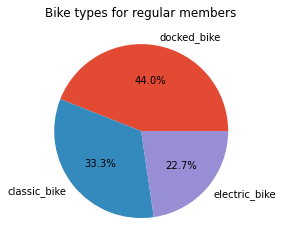

In [22]:
df_clean_member_rideable = df_clean_member['rideable_type'].value_counts()
labels_member_rideable = ['docked_bike','classic_bike','electric_bike']
plt.pie(df_clean_member_rideable,labels=labels_member_rideable,autopct='%1.1f%%')
plt.title('Bike types for regular members',fontsize=12)

Text(0.5, 1.0, 'Bike types for casual members')

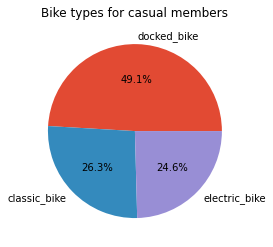

In [23]:
df_clean_casual_rideable = df_clean_casual['rideable_type'].value_counts()
labels_casual_rideable = ['docked_bike','classic_bike','electric_bike']
plt.pie(df_clean_casual_rideable,labels=labels_member_rideable,autopct='%1.1f%%')
plt.title('Bike types for casual members',fontsize=12)

There is slice difference that regular members prefer classic bilkes than casual members

Text(0, 0.5, 'Counting number of start station')

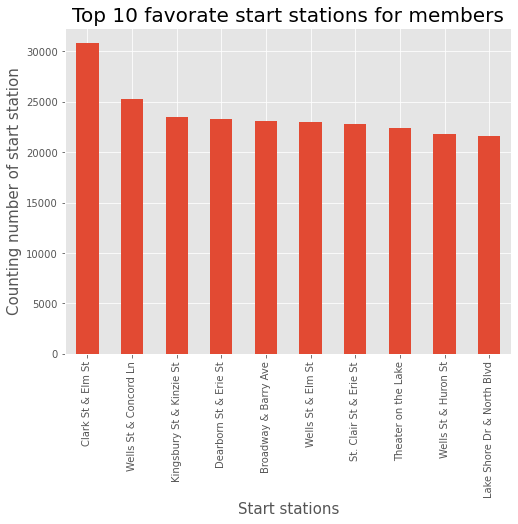

In [38]:
plt.figure(figsize=(8,6))
df_clean_member['start_station_name'].value_counts().iloc[:10].plot.bar()
plt.title('Top 10 favorate start stations for members',fontsize=20)
plt.xlabel('Start stations',fontsize=15)
plt.ylabel('Counting number of start station',fontsize=15)

Text(0, 0.5, 'Counting number of start station')

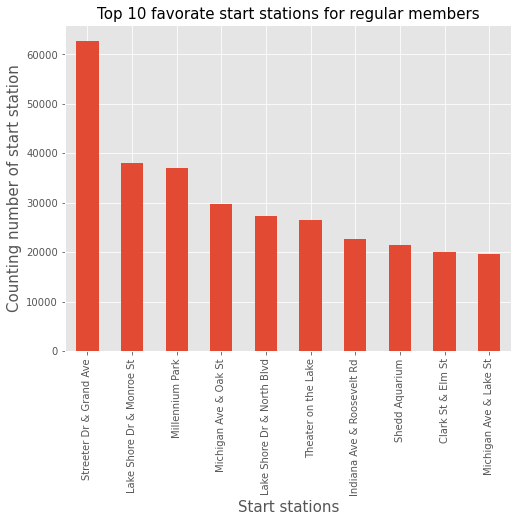

In [39]:
plt.figure(figsize=(8,6))
df_clean_casual['start_station_name'].value_counts().iloc[:10].plot.bar()
plt.title('Top 10 favorate start stations for regular members',fontsize=15)
plt.xlabel('Start stations',fontsize=15)
plt.ylabel('Counting number of start station',fontsize=15)

### Comparison of number of rides

Text(0, 0.5, 'Numerber of rides')

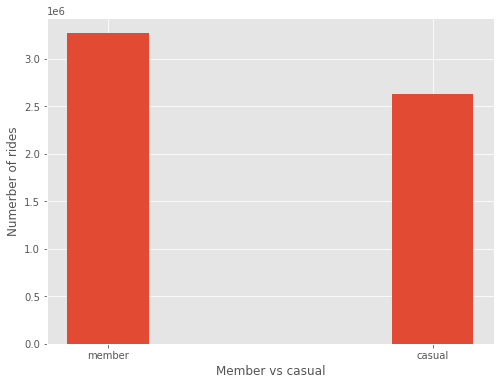

In [40]:
X_member_casual = ['member','casual']
y_nums_member_casual = [df_clean_member.shape[0],
                        df_clean_casual.shape[0]]
plt.figure(figsize=(8,6))
plt.bar(X_member_casual,y_nums_member_casual,width = 0.25)
plt.xlabel('Member vs casual')
plt.ylabel('Numerber of rides')

There is higher number of rides from regular members than casual riders, which is not surprising. Some of the rides may come from the same rider. They are not charged again within certain period of time. It is indicated that regular members use bikes as a transport more frequently in a day.

### Comparison of the average speed 

Text(0, 0.5, 'Average hourly ride distance ')

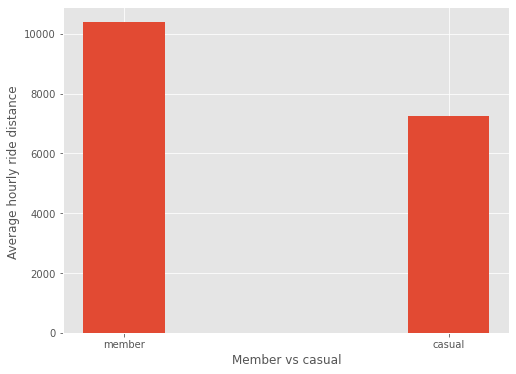

In [37]:
y_speed_member_casual = [df_clean_member['hourly_ride_distance'].mean(),
                        df_clean_casual['hourly_ride_distance'].mean()]
plt.figure(figsize=(8,6))
plt.bar(X_member_casual,y_speed_member_casual,width = 0.25)
plt.xlabel('Member vs casual')
plt.ylabel('Average hourly ride distance ')

It is noticeble that the average speed of members is much higher than casual riders. Chances are that the distance for riders is calculated by the start and end of coordinates (by the latitude and longitude). Casual rides may exprince a curve-like course without a certain final destination, while the regular rider usually come with purposes of daily work or exercises so that their tracks can be straight forward. This can be confirmed by the riding duration.  

Text(0, 0.5, 'ride_time_hour')

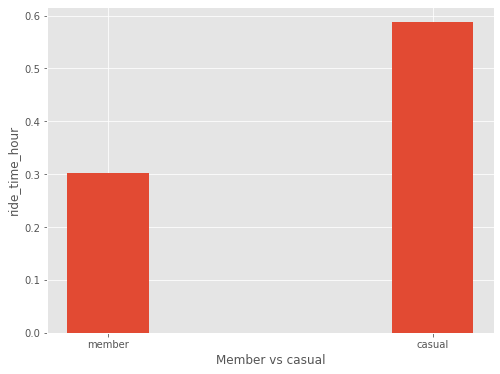

In [41]:
y_ride_time_member_casual = [df_clean_member['ride_time_hour'].mean(),
                        df_clean_casual['ride_time_hour'].mean()]
plt.figure(figsize=(8,6))
plt.bar(X_member_casual,y_ride_time_member_casual,width = 0.25)
plt.xlabel('Member vs casual')
plt.ylabel('ride_time_hour')

Casual rides always spend a lot time during the trip, but the distance between the start and the end can always be shorter than the regular members. It can be speculated that the tracks for the casual riders are not in a line or some addtional stops may be added in the trip. They may stay for a while during the trip like shopping or park excerses. 


## Mean value analysis of riding hours

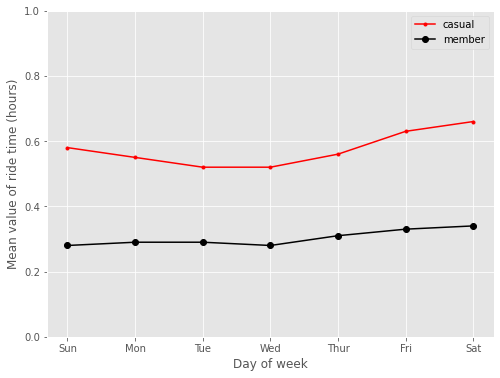

In [35]:
y_casual = []
for i in range(7):
    df_clean_casual_day = df_clean_casual[df_clean_casual['day_of_week']==i]
    mean_value = df_clean_casual_day['ride_time_hour'].mean()
    mean_value = round(mean_value,2)
    y_casual.append(mean_value)
    #print("Casual: mean value of day "+str(i)+": "+str(mean_value))



y_member = []
for i in range(7):
    df_clean_member_day = df_clean_member[df_clean_member['day_of_week']==i]
    mean_value = df_clean_member_day['ride_time_hour'].mean()
    mean_value = round(mean_value,2)
    y_member.append(mean_value)
    #print("Member: mean value of day "+str(i)+": "+str(mean_value))
X_day = ['Sun','Mon','Tue','Wed','Thur','Fri','Sat']
plt.figure(figsize=(8,6))
plt.plot(X_day,y_casual,'.r-',label="casual")
plt.plot(X_day,y_member,'-ok',label='member')
plt.legend()
plt.xlabel('Day of week')
plt.ylabel('Mean value of ride time (hours)')
plt.ylim((0,1))
plt.show()

Overall, there is an increasing demand in the weekend (Friday and Saturday). The increasing rate is higher for casual riders.

###  Comparisons of average riding time in different Seasons

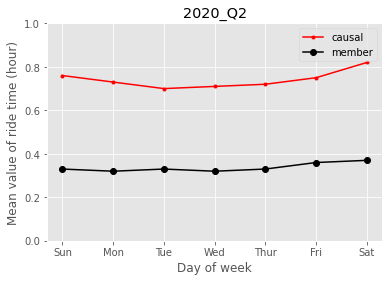

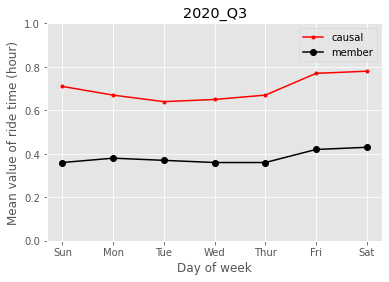

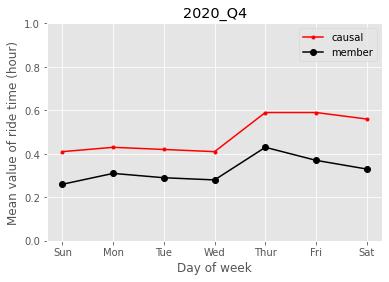

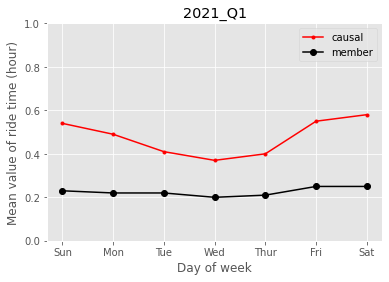

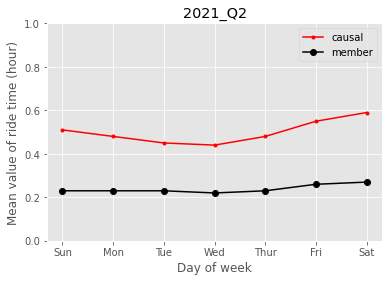

In [30]:
df_seasons = [df_2020_q2,df_2020_q3,df_2020_q4,df_2021_q1,df_2021_q2]
titles = {id(df_2020_q2):'2020_Q2',id(df_2020_q3):'2020_Q3',id(df_2020_q4):'2020_Q4',id(df_2021_q1):'2021_Q1',id(df_2021_q2):'2021_Q2'}
for df_season in df_seasons:
    df = pd.concat(df_season)
    data_engineering_process(df)
    df_clean = data_cleaning_process(df)
    y_casual = []
    for i in range(7):
        df_clean_casual = df_clean[df_clean['member_casual']=='casual']
        df_clean_casual_day = df_clean_casual[df_clean_casual['day_of_week']==i]
        mean_value = df_clean_casual_day['ride_time_hour'].mean()
        mean_value = round(mean_value,2)
        y_casual.append(mean_value)
        #print("Casual: mean value of day "+str(i)+": "+str(mean_value))



    y_member = []
    for i in range(7):
        df_clean_member = df_clean[df_clean['member_casual']=='member']
        df_clean_member_day = df_clean_member[df_clean_member['day_of_week']==i]
        mean_value = df_clean_member_day['ride_time_hour'].mean()
        mean_value = round(mean_value,2)
        y_member.append(mean_value)
        #print("Member: mean value of day "+str(i)+": "+str(mean_value))
    
    X_day = ['Sun','Mon','Tue','Wed','Thur','Fri','Sat']
    plt.plot(X_day,y_casual,'.r-',label="causal")
    plt.plot(X_day,y_member,'-ok',label='member')
    plt.legend()
    plt.xlabel('Day of week')
    plt.ylabel('Mean value of ride time (hour)')
    plt.ylim((0,1))
    plt.title(titles[id(df_season)])
    plt.show()

The ride time of regular members over the day of week is quit steady all year round. Fluctuations is more apparent for casual riders. There is a decreasing demand since Q4 of 2020 for both casual and member riders perhaps due to the restriction caused by pandemic.

However, mean value analysis is rough. To gain deep insigt we need to investigate other statistical varibles.

## Riding time distribution analysis

Text(0, 0.5, 'Numbers of ride')

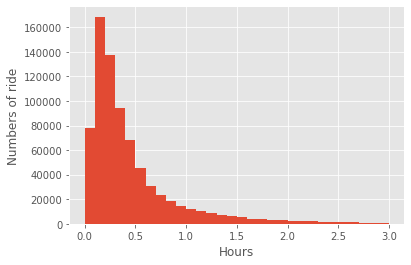

In [31]:
n_bin = 30
plt.hist(df_clean_casual['ride_time_hour'],range = (0,3),bins= n_bin)
plt.xlabel('Hours')
plt.ylabel('Numbers of ride')
plt.title('Riding time distribution for casual members')

Text(0, 0.5, 'Number of rides')

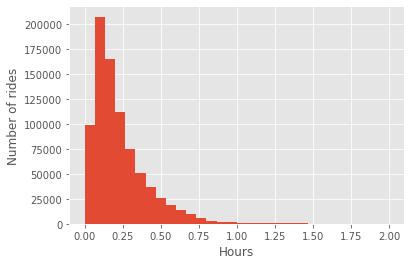

In [32]:
n_bin = 30
plt.hist(df_clean_member['ride_time_hour'],range = (0,2),bins= n_bin)
plt.xlabel('Hours')
plt.ylabel('Number of rides')
plt.title('Riding time distribution for regular members')

Casual riders have a wider range of riding hours (0 hr - 3 hrs) while regular members have a relatively concerntrated range (0 hr - 1.5 hrs).
It demonstrates regular members have a less varience of riding hours than causual riders. 

## Geometrical analysis

## Geometrical distribution of top 20 favorite starting station 

In [33]:
top_start_station_member = df_clean_member.groupby('start_station_name').agg({'start_station_name':'count','start_lat':'mean','start_lng':'mean'}).rename(columns={'start_station_name':'num_start_station_name'}).sort_values(by=['num_start_station_name'],ascending=False).iloc[:20]
top_start_station_casual = df_clean_casual.groupby('start_station_name').agg({'start_station_name':'count','start_lat':'mean','start_lng':'mean'}).rename(columns={'start_station_name':'num_start_station_name'}).sort_values(by=['num_start_station_name'],ascending=False).iloc[:20]
top_start_station_map = folium.Map(location=[top_start_station_member['start_lat'].mean(),top_start_station_member['start_lng'].mean()], zoom_start=12)
for index, location_info in top_start_station_member.iterrows():
    folium.features.CircleMarker(
        [location_info['start_lat'], location_info['start_lng']],
        radius=location_info['num_start_station_name']/4000,
        color='red',
        fill=False,
        tooltip=str(location_info['num_start_station_name'])+' regular members',
        #fill_color='darkred',
        #fill_opacity=1,
        opacity=1
    ).add_to(top_start_station_map)
for index, location_info in top_start_station_casual.iterrows():
    folium.features.CircleMarker(
        [location_info['start_lat'], location_info['start_lng']],
        radius=location_info['num_start_station_name']/4000,
        color='blue',
        fill=False,
        tooltip=str(location_info['num_start_station_name'])+' casual members',
        #fill_color='blue',
        #fill_opacity=0.1,
        opacity=1
    ).add_to(top_start_station_map)
top_start_station_map

The most top favorite starting stations of regular members are mainly located around commercial areas. Apart from those areas, the casual members are mainly distributed around recreational areas like public park, memorial, dock.